# Load Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, mean_squared_error, explained_variance_score

from srcs.utils import load_data, print_scores, get_scores, calculate_metrics
import time
import tracemalloc
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Load Data

In [2]:
df = load_data()
df

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82,0.0
3,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82,0.0
5,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22,0.0
10,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72,0.0
11,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93,0.0
6114327,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11,0.0
6114328,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82,0.0


# Feature Engineering

In [3]:
# your feature engineering and data preprocessing here
# e.g.
df.drop(columns=["Area"], inplace=True)
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

df["VehAge"] = df["VehAge"].clip(upper=np.percentile(df["VehAge"], 97.5))
df["DrivAge"] = df["DrivAge"].clip(upper=np.percentile(df["DrivAge"], 97.5))

df = pd.get_dummies(df, columns=["VehBrand", "VehPower", "VehGas", "Region"], drop_first=True)

df["Density"] = np.log(df["Density"])
df["VehAge2"] = df["VehAge"] ** 2
df["DrivAge2"] = df["DrivAge"] ** 2

df["VehAge3"] = df["VehAge"] ** 3
df["DrivAge3"] = df["DrivAge"] ** 3

df["VehAge4"] = df["VehAge"] ** 4
df["DrivAge4"] = df["DrivAge"] ** 4

df["VehAge5"] = df["VehAge"] ** 5
df["DrivAge5"] = df["DrivAge"] ** 5

df["VehAge6"] = df["VehAge"] ** 6
df["DrivAge6"] = df["DrivAge"] ** 6


In [4]:
# do not change the fellowing code
X = df.drop(columns=['ClaimNb'])
y = df['ClaimNb']

# data integrity check
# make sure we do not drop some rows
assert X.shape[0] == load_data().shape[0]

# Model Evaluation


In [5]:
# use to store the scores of each model
results = []

## Naive Poisson Regression

In [6]:
scores = get_scores(model_name="Naive Poisson Regression")
"""
Please specify the model here
"""
from sklearn.linear_model import PoissonRegressor


naive_poisson = PoissonRegressor()

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = naive_poisson.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

  File "D:\workspace\GraduateGrade2Term2LSEWT\PGPC2024\.venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Model: Naive Poisson Regression
Train MAE:0.0568,std:0.0002
Test  MAE:0.0568,std:0.0008
Train Explained Variance:0.0000,std:0.0000
Test  Explained Variance:0.0000,std:0.0000
Train Time:0.20,std:0.06
Test  Time:0.21,std:0.01


## Zero-inflated Poisson Regression

## XGBoost Poisson Regression

In [7]:
scores = get_scores(model_name="XGBoost Poisson Regression")
"""
Please specify the model here
"""
from xgboost import XGBRegressor

xgboost_poisson_model = XGBRegressor(objective="count:poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = xgboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

Model: XGBoost Poisson Regression
Train MAE:0.0157,std:0.0001
Test  MAE:0.0165,std:0.0004
Train Explained Variance:0.7229,std:0.0016
Test  Explained Variance:0.7077,std:0.0060
Train Time:15.68,std:0.60
Test  Time:11.59,std:0.18


## LightGBM Poisson Regression

In [8]:
scores = get_scores(model_name="LightGBM Poisson Regression")
"""
Please specify the model here
"""
from lightgbm import LGBMRegressor

lightgbm_poisson_model = LGBMRegressor(objective="poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = lightgbm_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1273
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 59
[LightGBM] [Info] Start training from score -2.740962
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1272
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 59
[LightGBM] [Info] Start training from score -2.734688
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

## CatBoost Poisson Regression

In [9]:
scores = get_scores(model_name="CatBoost Poisson Regression")
"""
Please specify the model here
"""
from catboost import CatBoostRegressor

catboost_poisson_model = CatBoostRegressor(loss_function="Poisson")

kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in tqdm(kf5.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    """Train the model"""
    tracemalloc.start()
    start = time.time()

    # enter your model training here
    model = catboost_poisson_model.fit(X_train, y_train, sample_weight=X_train["Exposure"])

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["train_time"].append(end - start)
    scores["train_memory"].append(peak)

    """Test the model"""
    start = time.time()
    tracemalloc.start()

    # enter your model testing here
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    end = time.time()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    scores["test_time"].append(end - start)
    scores["test_memory"].append(peak)

    """Calculate the Metrics"""
    scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)

results.append(scores)
print_scores(scores)

0it [00:00, ?it/s]

0:	learn: 0.8854249	total: 208ms	remaining: 3m 27s
1:	learn: 0.7888189	total: 271ms	remaining: 2m 15s
2:	learn: 0.7059053	total: 334ms	remaining: 1m 51s
3:	learn: 0.6379895	total: 401ms	remaining: 1m 39s
4:	learn: 0.5762524	total: 459ms	remaining: 1m 31s
5:	learn: 0.5232427	total: 528ms	remaining: 1m 27s
6:	learn: 0.4769563	total: 593ms	remaining: 1m 24s
7:	learn: 0.4359326	total: 671ms	remaining: 1m 23s
8:	learn: 0.4016047	total: 726ms	remaining: 1m 19s
9:	learn: 0.3711009	total: 786ms	remaining: 1m 17s
10:	learn: 0.3444095	total: 842ms	remaining: 1m 15s
11:	learn: 0.3212148	total: 897ms	remaining: 1m 13s
12:	learn: 0.3004074	total: 957ms	remaining: 1m 12s
13:	learn: 0.2822753	total: 1.01s	remaining: 1m 11s
14:	learn: 0.2660023	total: 1.08s	remaining: 1m 10s
15:	learn: 0.2516874	total: 1.14s	remaining: 1m 9s
16:	learn: 0.2389042	total: 1.19s	remaining: 1m 9s
17:	learn: 0.2275068	total: 1.25s	remaining: 1m 8s
18:	learn: 0.2173506	total: 1.32s	remaining: 1m 7s
19:	learn: 0.2082555	total

## TODO:Your Model Here

In [10]:
# scores = get_scores(model_name="Your Model name")
# """
# Please specify the model here
# """
# # TODO: enter your model here,e.g.
# # your_model = YourModel()
# 
# 
# kf5 = KFold(n_splits=5, shuffle=True, random_state=42)
# for train_index, test_index in kf5.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
# 
#     """Train the model"""
#     tracemalloc.start()
#     start = time.time()
# 
#     # enter your model training here
#     # TODO: enter your model training here,e.g.
#     # model = your_model.fit(X_train, y_train)
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["train_time"].append(end - start)
#     scores["train_memory"].append(peak)
# 
#     """Test the model"""
#     start = time.time()
#     tracemalloc.start()
# 
#     # enter your model testing here
#     # TODO: enter your model testing here
#     # make sure the output is y_pred_train and y_pred_test,e.g.
#     # y_pred_train = model.predict(X_train)
#     # y_pred_test = model.predict(X_test)
# 
#     end = time.time()
#     _, peak = tracemalloc.get_traced_memory()
#     tracemalloc.stop()
#     scores["test_time"].append(end - start)
#     scores["test_memory"].append(peak)
# 
#     """Calculate the Metrics"""
#     scores = calculate_metrics(scores, y_train, y_pred_train, y_test, y_pred_test)
# 
# results.append(scores)
# print_scores(scores)

# Summary

In [11]:
df_results = pd.DataFrame()
for result in results:
    df_results = pd.concat([df_results, pd.DataFrame(result)])

df_results.groupby("model").mean().sort_values(by="test_MAE")

,train_MAE,test_MAE,train_explained_variance,test_explained_variance,train_time,test_time,train_memory,test_memory
model,,,,,,,,
CatBoost Poisson Regression,0.015929,0.016490,7.186847e-01,7.087528e-01,73.281673,47.040147,179206.6,5519488.0
LightGBM Poisson Regression,0.016296,0.016492,7.122094e-01,7.087165e-01,3.138544,0.975142,512064843.6,516387097.2
XGBoost Poisson Regression,0.015688,0.016548,7.229367e-01,7.077356e-01,15.681021,11.590509,538810191.2,538784873.6
Naive Poisson Regression,0.056753,0.056753,6.661338e-17,8.881784e-17,0.200559,0.205367,512060862.6,512049502.4


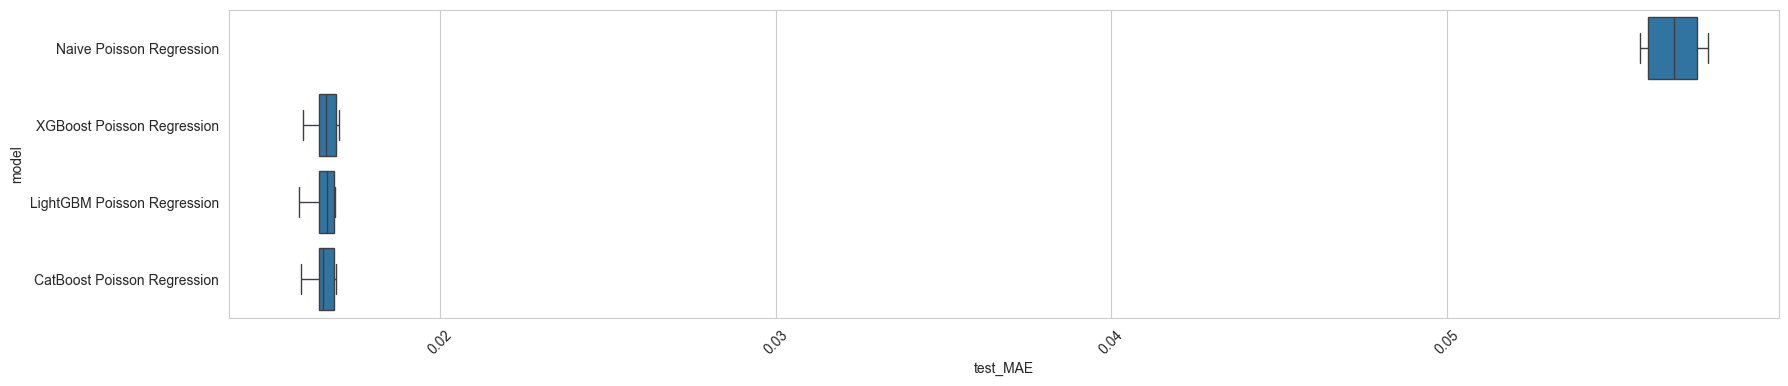

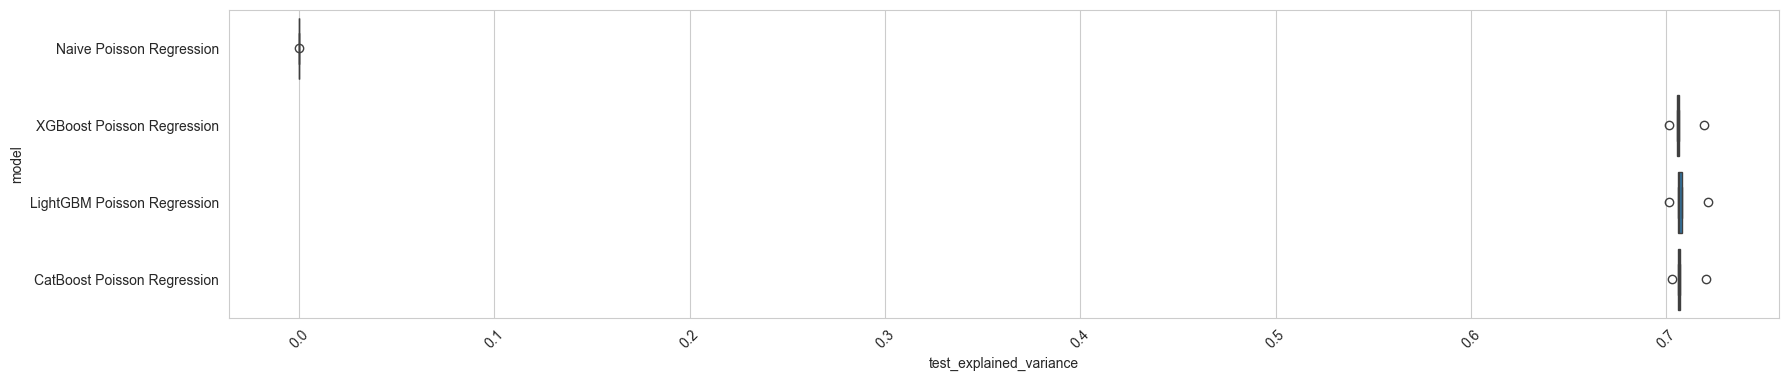

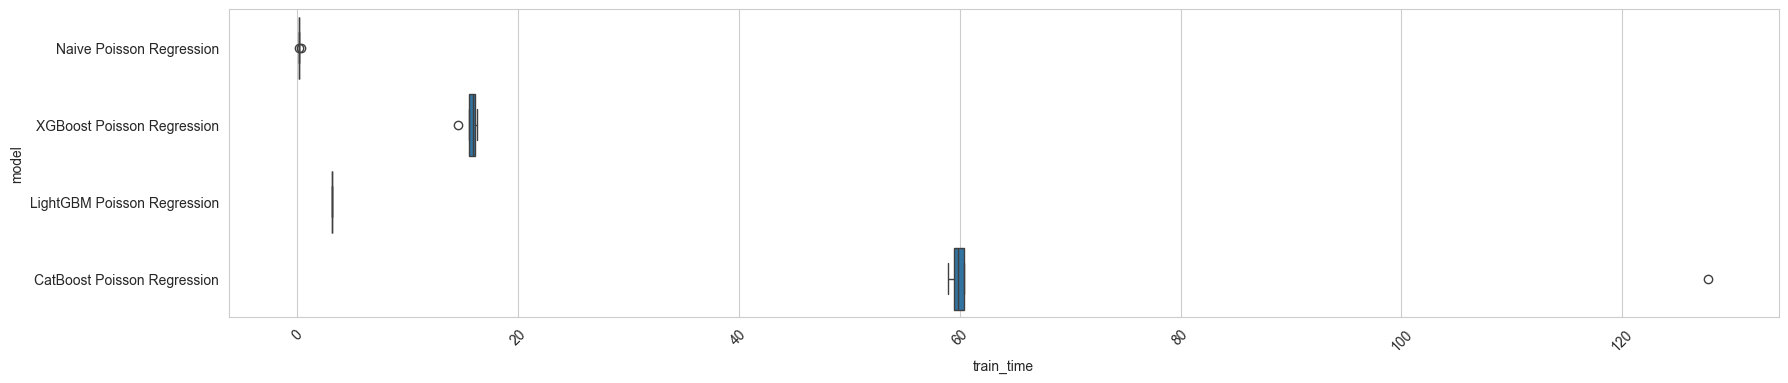

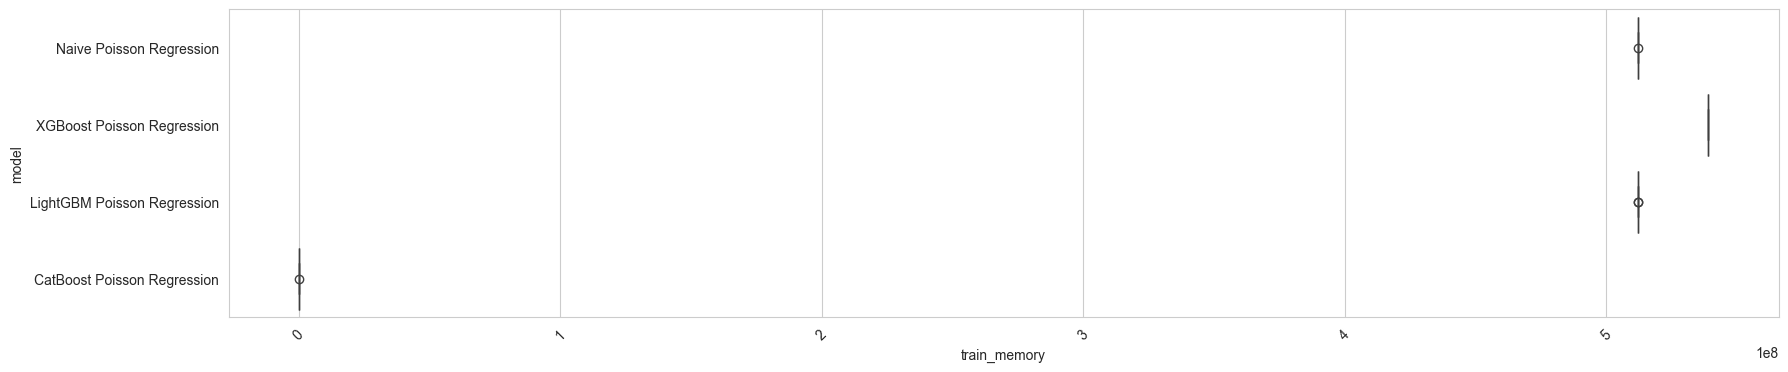

In [12]:
interested_metrics = ["test_MAE", "test_explained_variance", "train_time", "train_memory"]

for metric in interested_metrics:
    plt.figure(figsize=(20, len(results)))
    sns.boxplot(data=df_results, y="model", x=metric)
    plt.xticks(rotation=45)
    plt.show()